# Exercises Day04

In [14]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy 
import matplotlib.pyplot as plt
from helper_functions import *

def normpdf(x : float, mu : float, sigma : float) -> float:
    """
        Normal distribution probability density function.
        
        :param x: x value
        :param mu: mean
        :param sigma: standard deviation
        
        :return: probability density function value
    """
    return 1/(np.sqrt(2 * np.pi) * sigma) * np.exp(-1.0 / 2 * ((mu - x) / sigma)**2)

def compute_confidence_interval_sample(data : list[float], confidence : float = 0.95, normal : bool = False ) -> list[float]:
    """
        Compute the confidence interval of the mean of the data.
        :param data: list of data
        :param confidence: confidence level
        :param normal: whether of not the data is assumed normal distributed
        
        :return: confidence interval of the mean of the data
    """
    N = len(data)
    alpha = 1 - confidence

    data = np.array(data)
    if normal:
        conf_mean = [data.mean() + data.std()/np.sqrt(N) * scipy.stats.t.cdf(alpha/2, N - 1), data.mean() + data.std()/np.sqrt(N) * scipy.stats.t.cdf(1-alpha/2, N - 1)]
    else:
        conf_mean = [data.mean() - confidence * data.std()/np.sqrt(N), data.mean() + confidence * data.std()/np.sqrt(N)]
    
    return conf_mean


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Ex01

**Estimate an integral $\int_0^1 e^x d x$ by simulation (the Crude Monte Carlo estimator). Use e.g. an estimator based on 100 samples and present the result as the point estimator and a confidence interval.**

In [2]:
# We assume that we may use numpy because we already went through with sampling from numpy once
# although you didn't explicitely state it as last time...
NUM_SAMPLES = 100

crude_monte_carlo = np.exp(np.random.uniform(0, 1, NUM_SAMPLES))
crude_mc_estimate = crude_monte_carlo.mean()
crude_mc_conf = compute_confidence_interval_sample(crude_monte_carlo)

print("Crude Monte Carlo (point) estimate: ", crude_mc_estimate)
print(f"Crude Monte Carlo confidence interval: [{crude_mc_conf[0]:.4f}, {crude_mc_conf[1]:.4f}]")
print(f"Crude Monte Carlo variance: {crude_monte_carlo.var():.4f}")

Crude Monte Carlo (point) estimate:  1.7156186405469205
Crude Monte Carlo confidence interval: [1.6675, 1.7637]
Crude Monte Carlo variance: 0.2566


## Ex02

**Estimate an integral $\int_0^1 e^x d x$ using antithetic variables, with comparable computer ressources.**

In [3]:
# Again we assume numpy is allowed :D

num_samples_antithetic = NUM_SAMPLES // 50  # <-- Going from crude to antithetic, reduces the variance by a factor of 50 (see slide 12 of 'slide7m1.pdf')

U = np.random.uniform(0, 1, NUM_SAMPLES)
X = np.exp(U)
Z = np.exp(1 - U)
Y = (X + Z) / 2

antithetic_estimate = Y.mean()
antithetic_conf = compute_confidence_interval_sample(Y)


print(f"Antithetic (point) estimate (with {num_samples_antithetic} samples): ", antithetic_estimate)
print(f"Antithetic confidence interval: [{antithetic_conf[0]:.4f}, {antithetic_conf[1]:.4f}]\n")
print(f"Crude Monte Carlo (point) estimate (with {NUM_SAMPLES} samples): ", crude_mc_estimate)
print(f"Crude Monte Carlo confidence interval: [{crude_mc_conf[0]:.4f}, {crude_mc_conf[1]:.4f}]")

Antithetic (point) estimate (with 2 samples):  1.7286747783492726
Antithetic confidence interval: [1.7226, 1.7347]

Crude Monte Carlo (point) estimate (with 100 samples):  1.7156186405469205
Crude Monte Carlo confidence interval: [1.6675, 1.7637]


## Ex03

**Estimate an integral $\int_0^1 e^x d x$ using a control variable, with comparable computer ressources.**


In [4]:
cov = lambda x,y: np.sum((x - x.mean()) * (y - y.mean())) / (len(x) - 1) 

num_samples_control = 100

U = np.random.uniform(0, 1, num_samples_control) # Here U = Y from slides 
X = np.exp(U)

c =  - cov(U, X) / U.var()

Z = X + c * (U - 0.5)

control_estimate = Z.mean()
control_conf = compute_confidence_interval_sample(Z)


print(f"Control sampling (point) estimate (with {num_samples_control} samples): ", control_estimate)
print(f"Antithetic confidence interval: [{control_conf[0]:.4f}, {control_conf[1]:.4f}]\n")

print(f"Crude Monte Carlo (point) estimate (with {NUM_SAMPLES} samples): ", crude_mc_estimate)
print(f"Crude Monte Carlo confidence interval: [{crude_mc_conf[0]:.4f}, {crude_mc_conf[1]:.4f}]")



Control sampling (point) estimate (with 100 samples):  1.7171917641228822
Antithetic confidence interval: [1.7112, 1.7232]

Crude Monte Carlo (point) estimate (with 100 samples):  1.7156186405469205
Crude Monte Carlo confidence interval: [1.6675, 1.7637]


## Ex04

**Estimate an integral $\int_0^1 e^x d x$ using stratified sampling, with
comparable computer ressources.**


In [5]:
num_samples_stratified = 10
m = 10

W = 0
for i in range(m):
    W += np.exp(np.random.uniform((1 / m) * i, (1 / m) * (i + 1), num_samples_stratified) / m + i/m)

W /= m

stratified_estimate = W.mean()
stratified_conf = compute_confidence_interval_sample(W)

print(f"Stratified sampling (point) estimate (with {num_samples_stratified * m} samples): ", stratified_estimate)
print(f"Stratified confidence interval: [{stratified_conf[0]:.4f}, {stratified_conf[1]:.4f}]\n")

print(f"Crude Monte Carlo (point) estimate (with {NUM_SAMPLES} samples): ", crude_mc_estimate)
print(f"Crude Monte Carlo confidence interval: [{crude_mc_conf[0]:.4f}, {crude_mc_conf[1]:.4f}]")

Stratified sampling (point) estimate (with 100 samples):  1.7324494904420242
Stratified confidence interval: [1.7320, 1.7329]

Crude Monte Carlo (point) estimate (with 100 samples):  1.7156186405469205
Crude Monte Carlo confidence interval: [1.6675, 1.7637]


## Ex05

**Use control variates to reduce the variance of the estimator in
exercise 04 (Poisson arrivals).**

$$
    \tilde{X} = X + c_1 ( \bar{X}_{arrival} - \frac{1}{\lambda})
$$

$X$ is here blocked rate (vector of all the samples), while $\bar{X}_{arrival}$ is the arrival rate (vector of all the arrival times) and $\frac{1}{\lambda}$ is the theoretical mean of arrivals rates.

In [6]:
block_fraction, arrivals = blocking_simulation()

block_fraction = np.array(block_fraction); arrivals = np.array(arrivals)
c = cov(block_fraction, arrivals) / arrivals.var()
X = block_fraction + c * (arrivals - ARRIVAL_MEAN) # <-- ARRIVAL_MEAN is defined in helperfunction.py


# exact 
A = ARRIVAL_MEAN * SERVICE_MEAN

B = (A**m / np.math.factorial(m)) / np.sum([(A**i) / np.math.factorial(i) for i in range(m+1)])

print(f"Orignal estimate: {block_fraction.mean():.5f} \tApplied control variates {X.mean():.5f} \tExact solution {B:.5f}")
print(f"Orignal estimate residual: {np.abs((block_fraction.mean() - B)):.5f} \tApplied control variates residual: {np.abs(X.mean() - B):.5f}")


run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
Orignal estimate: 0.12037 	Applied control variates 0.12056 	Exact solution 0.12166
Orignal estimate residual: 0.00129 	Applied control variates residual: 0.00110


## Ex06

**Demonstrate the effect of using common random numbers in exercise 4 for the difference between Poisson arrivals (Part 1) and a renewal process with hyperexponential interarrival times.**

*Remark: You might need to do some thinking and some re-programming* 



In [19]:
def sample_arrival_poisson_process_sampleU(U) -> float:
    """
        Sample the service time from an exponential distribution.
        
        :return: service time (as a float)
    """
    return -np.log(U)/(1/SERVICE_MEAN)


def sample_arrival_hyper_exponential(U) -> float:
    """
    """
    p = np.random.binomial(n=1,p= HYPER_PROB)

    if p:
        return -np.log(U)/(1/HYPER_MEAN[0])
    else:
        return -np.log(U)/(1/HYPER_MEAN[1])

U = np.random.uniform(0,1,(10,10001))

arrivals_sample_exp = sample_arrival_poisson_process_sampleU(U)
arrivals_sample_hexp = sample_arrival_hyper_exponential(U)


## Simulation
def blocking_simulation_sampleU(
    simulation_runs : int = 10,
    m : int = 10,
    N : int = 10000,
    sample_arrival :np.ndarray[np.ndarray[float]] = arrivals_sample_exp,
    sample_service_time : Callable[[], float] = sample_service_time_exponential
    ) -> tuple[list[float], list[float]]:
    """
        A function for runinng multiple simulations of a blocking system.
        
        :param simulation_runs: number of simulations to run
        :param m: number of service units
        :param N: number of customers
        :param sample_arrival: function for sampling arrival time
        :param sample_service_time: function for sampling service time
        
        :return: list of blocked fractions and list of average arrival times
    """
    # NOTE: Maybe use burn in period...?
    
    blocked_fractions = []
    arrival_times = []
    for i in range(simulation_runs):
        print(f"run {i+1}")
        custmer_count = 0
        global_time = 0
        event_counter = 0
        block_count = 0
        arrivals = 0


        # lists
        event_list = []
        service_units_status = [False for _ in range(m)]    # <-- Indicates whether the service units are occupied or not
        

        # First arrival
        first_arrival = sample_arrival[i,0]
        event_list.append(Event('arrival', global_time + first_arrival))
        arrivals += first_arrival
        
        global_time += first_arrival
        event_list.append(Event('departure', global_time + first_arrival))
        service_units_status[0] = True # <-- unit 1 is occupied

        while custmer_count < N:
            
            current_event = event_list[event_counter]

            # Increment global time
            global_time = current_event.time

            if current_event.event_type == 'arrival':
                custmer_count += 1

                # Check for free service units
                indx, available = check_available_service(service_units_status)
                
                if available:
                    # Insert departure event and depend to eventlist
                    
            
                    departure_event = Event('departure', global_time + sample_service_time())
                    event_list = apend_event(event_list, departure_event)

                    # Take service unit
                    service_units_status[indx] = True # <-- unit indx is occupied

                if not available:
                    # Costumer blocked
                    block_count += 1
                
                # insert time for next arrival
                new_arrival = sample_arrival[i,custmer_count]
                arrivals += new_arrival
                arrival_event = Event('arrival', global_time + new_arrival)
                event_list = apend_event(event_list, arrival_event)

            elif current_event.event_type == 'departure': 
                # Free the service unit for the current departure event
                for indx, unit_occupied in enumerate(service_units_status):
                    if unit_occupied:
                        service_units_status[indx] = False # <-- unit indx is free
                        break
                        
            # increment event counter
            event_counter += 1
        
        blocked_fractions.append(block_count / N)
        arrival_times.append(arrivals / N)
    
    return blocked_fractions, arrival_times


block_fraction_exp, _ = blocking_simulation_sampleU(sample_arrival = arrivals_sample_exp)
block_fraction_hexp, _ = blocking_simulation_sampleU(sample_arrival = arrivals_sample_hexp)

run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10
run 1
run 2
run 3
run 4
run 5
run 6
run 7
run 8
run 9
run 10


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


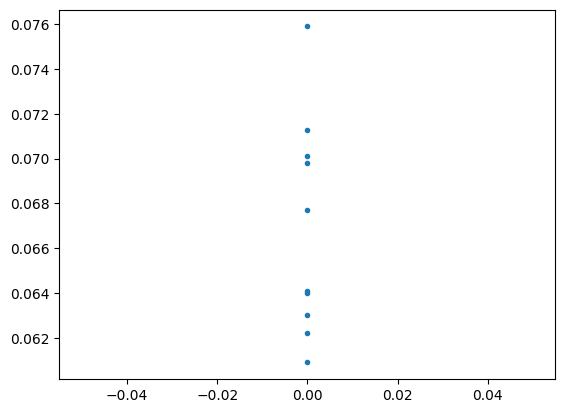

In [23]:
print(block_fraction_exp)
plt.figure()
plt.plot(block_fraction_exp,block_fraction_hexp,'.')
plt.show()

## Ex07

In [ ]:
NUM_SAMPLES = 100000

h = lambda x:   scipy.stats.norm.ppf(U)

U = np.random.uniform(0, 1, NUM_SAMPLES)
X = 1-  scipy.stats.norm.isf(U)

XX =  np.arange(-4, 4, 0.01)
Y = np.array([normpdf(x, 0, 1) for x in XX])

plt.figure()
plt.hist(X, density=True, bins=50)
plt.plot(XX,Y)
plt.show()

In [ ]:
# Crude monte carlo? YES!
NUM_SAMPLES= 100000
X =  np.random.normal(0, 1, NUM_SAMPLES)
a = 2 # Try different values


print(np.sum(X<a)/NUM_SAMPLES)
print(scipy.stats.norm.cdf(a,0,1)) # NO


# Importance sampling


In [104]:
a = 2 

NUM_SAMPLES= 100
U = np.random.uniform(0, np.abs(a), NUM_SAMPLES)
X = scipy.stats.norm.cdf(U)

print(X )




[0.82286919 0.58169317 0.82620987 0.83646022 0.68552121 0.90556778
 0.95148263 0.68027052 0.58920701 0.95440663 0.96714824 0.90584545
 0.85600321 0.96086674 0.58589029 0.85262498 0.97382994 0.86563782
 0.84782187 0.931686   0.94036981 0.55173978 0.90799244 0.9443886
 0.97450245 0.55242665 0.96036192 0.94791253 0.94804956 0.9455911
 0.83389132 0.9768906  0.92160398 0.83796981 0.51204398 0.96697783
 0.87661025 0.93613014 0.63630807 0.60550311 0.77176787 0.86168071
 0.55944815 0.96040907 0.96684148 0.7859911  0.82960052 0.69428506
 0.8417158  0.5729112  0.91046426 0.61966132 0.87744817 0.73139968
 0.90194648 0.52930794 0.89886338 0.7122255  0.68146887 0.58425694
 0.91989687 0.56536488 0.50292013 0.86010117 0.96214533 0.70508971
 0.89769111 0.93427    0.61924756 0.67027819 0.95487785 0.88132262
 0.9629169  0.97294435 0.70428656 0.56704589 0.54200531 0.79348209
 0.58894889 0.61868025 0.7533451  0.87118913 0.71789772 0.73552035
 0.95860625 0.90002053 0.75310256 0.92276051 0.81288842 0.779884

## Ex08

## Ex09